In [1]:
import cv2
import glob
import torch
import random
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# z = torch.randn(100, 3, 224, 224)

In [3]:
model_resize_shape = (224, 224)

In [4]:
cat_folder_path = "./cats/"
jpg_files = glob.glob(cat_folder_path + "/*.jpg")
cat_arr = []

for file_path in jpg_files:
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ( img_rgb.shape[0] >= model_resize_shape[0] and img_rgb.shape[1] >= model_resize_shape[1]):
        resized_cat_img = cv2.resize(img_rgb, (model_resize_shape[0], model_resize_shape[1]))
    
        cat_arr.append(np.array(resized_cat_img).reshape(-1, model_resize_shape[0], model_resize_shape[1]))

In [5]:
dog_folder_path = "./dogs/"
jpg_files = glob.glob(dog_folder_path + "/*.jpg")
dog_arr = []

for file_path in jpg_files:
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ( img_rgb.shape[0] >= model_resize_shape[0] and img_rgb.shape[1] >= model_resize_shape[1]):
        resized_dog_img = cv2.resize(img_rgb, (model_resize_shape[0], model_resize_shape[1]))
    
        dog_arr.append(np.array(resized_dog_img).reshape(-1, model_resize_shape[0], model_resize_shape[1]))
    

In [6]:

cats_dogs_imgs = dog_arr + cat_arr 
output_labels = [1 for _ in dog_arr] + [0 for _ in cat_arr]

# Combine the lists using zip
combined_lists = list(zip(cats_dogs_imgs, output_labels))

# Shuffle the combined list
random.shuffle(combined_lists)

# Unzip the shuffled list
cats_dogs_imgs_shuffled, output_labels_shuffled = zip(*combined_lists)



In [7]:
X_tensor = torch.from_numpy(np.array(cats_dogs_imgs_shuffled))
Y_tensor = torch.from_numpy(np.array(output_labels_shuffled))

In [8]:
class ResnetConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn_layer1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv_layer2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1)
        self.bn_layer2 = nn.BatchNorm2d(out_channels)
        self.conv_layer3 = nn.Conv2d(out_channels, out_channels * 2, kernel_size=1, stride=1)
        self.relu = nn.ReLU()
        
        self.identity_conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.identity_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):

        identity = x

        x = self.conv_layer1(x)
        x = self.bn_layer1(x)
        x = self.relu(x)

        x = self.conv_layer2(x)
        x = self.bn_layer2(x)
        x = self.relu(x)

        # identity dimension mismatch fix
        identity = self.identity_conv1x1(identity)
        identity = self.identity_bn(identity)

        x = torch.nn.functional.pad(x, (1, 1, 1, 1))

        x += identity
        x = self.relu(x)

        return x
        

In [9]:
class ResnetIdentityBlock(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv_layer1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)
        self.bn_layer = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU()
        self.conv_layer3x3 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1)

    def forward(self, x):
        identity = x
        x = self.conv_layer1x1(x)
        x = self.bn_layer(x)
        x = self.relu(x)
        
        x = self.conv_layer3x3(x)
        x = self.bn_layer(x)
        x = self.relu(x)

        x = self.conv_layer1x1(x)
        x = self.bn_layer(x)

        x = torch.nn.functional.pad(x, (1, 1, 1, 1))

        x += identity
        x = self.relu(x)

        
        return x

In [10]:
class Resnet50(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(3, 8, kernel_size=7, stride=2)
        self.bn_layer1 = nn.BatchNorm2d(num_features=8)
        self.relu = nn.ReLU()
        self.maxpool_layer1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_block_I = ResnetConvBlock(8, 16)
        self.identity_block_I = ResnetIdentityBlock(16)
        self.conv_block_II = ResnetConvBlock(16, 32)
        self.identity_block_II = ResnetIdentityBlock(32)
        self.conv_block_III = ResnetConvBlock(32, 64)
        self.identity_block_III = ResnetIdentityBlock(64)
        self.conv_block_IV = ResnetConvBlock(64, 128)
        self.identity_block_IV = ResnetIdentityBlock(128)

        self.avgpooling = nn.AvgPool2d(kernel_size=3, stride=7)
        self.linear_container = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1204),
            nn.ReLU(),
            nn.Linear(1204, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
            # nn.Softmax(dim=0),
        )

    def forward(self, x): 
        
        batch_size = x.shape[0]
        
        x = self.conv_layer1(x)
        x = self.bn_layer1(x)
        x = self.relu(x)
        x = self.maxpool_layer1(x)

        x = self.conv_block_I(x)
        x = self.identity_block_I(x)
        x = self.identity_block_I(x)
        
        x = self.conv_block_II(x)
        x = self.identity_block_II(x)
        x = self.identity_block_II(x)
        x = self.identity_block_II(x)

        x = self.conv_block_III(x)
        x = self.identity_block_III(x)
        x = self.identity_block_III(x)
        x = self.identity_block_III(x)
        x = self.identity_block_III(x)
        x = self.identity_block_III(x)

        x = self.conv_block_IV(x)
        x = self.identity_block_IV(x)
        x = self.identity_block_IV(x)
        x = self.identity_block_IV(x)

        x = self.avgpooling(x)
        x = self.linear_container(x.view(batch_size, -1))
        
        return x

In [11]:
resnet50 = Resnet50()

In [12]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=3e-4)

In [13]:
epochs = 100
i = 0
j = 0
batch_size = 64

In [14]:
# while j < 2000:
#     for k in range(35):
#         loss = loss_fn(resnet50(X_tensor[j:j + batch_size].float()), Y_tensor[j:j + batch_size].reshape(-1, 1).float())
#         print(f'BATCH {i + 1} | LOSS {loss} | {j}:{j + batch_size}')
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#     j += batch_size
#     i += 1

In [15]:
torch.save(resnet50.state_dict(), 'catdog.pth')

In [16]:
Y_tensor[:100].float()

tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 0.])

In [17]:
resnet50(X_tensor[:100].float().reshape(-1, 3, 224, 224))

tensor([[0.4912],
        [0.4911],
        [0.4912],
        [0.4910],
        [0.4912],
        [0.4911],
        [0.4912],
        [0.4912],
        [0.4912],
        [0.4910],
        [0.4910],
        [0.4912],
        [0.4911],
        [0.4911],
        [0.4910],
        [0.4911],
        [0.4910],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4910],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4912],
        [0.4911],
        [0.4912],
        [0.4912],
        [0.4910],
        [0.4912],
        [0.4912],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4911],
        [0.4911],
        [0.4912],
        [0.4910],
        [0.4912],
        [0.4911],
        [0.4912],
        [0.4911],
        [0.4912],
        [0

In [19]:
resnet50 = Resnet50()
# Load the saved state dictionary into the model
resnet50.load_state_dict(torch.load('catdog.pth'))

# Set the model to evaluation mode
resnet50.eval()  # Or model.train() if you want to continue training


Resnet50(
  (conv_layer1): Conv2d(3, 8, kernel_size=(7, 7), stride=(2, 2))
  (bn_layer1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool_layer1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block_I): ResnetConvBlock(
    (conv_layer1): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn_layer1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_layer2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (bn_layer2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_layer3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (identity_conv1x1): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (identity_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (identity_block_I): ResnetIdentityBlock(
    (relu): ReLU()
    (conv_layer1x1): Conv2d

In [20]:
import math
def evalutate_model(resnet50, X_tensor, Y_tensor):

    eval_index_start = 1100
    eval_index_end = 1300

    pred_vals = resnet50(X_tensor[eval_index_start:eval_index_end].float())

    pred_vals_thresholded = []
    print('Thresholding...')
    for pred in pred_vals:
        if pred >= 0.65:
            pred_vals_thresholded.append(1)
        else:
            pred_vals_thresholded.append(0)

    print('Thresholding complete')

    results_arr = np.array(pred_vals_thresholded - Y_tensor[eval_index_start:eval_index_end].detach().numpy())

    accuracy = 0
    for res in results_arr:
        if not res:
            accuracy += 1

    return accuracy / (eval_index_end - eval_index_start) * 100

In [21]:
evalutate_model(resnet50, X_tensor, Y_tensor)

Thresholding...
Thresholding complete


55.00000000000001

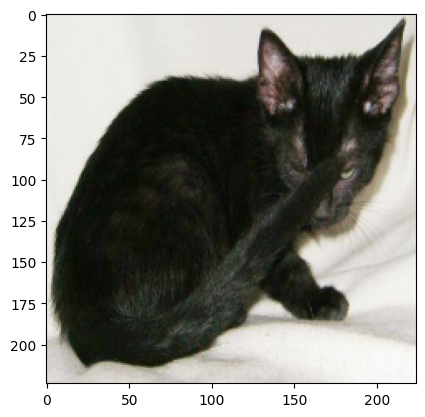

In [23]:
plt.imshow(X_tensor[456].reshape(224, 224, 3))

In [22]:
Y_tensor[0]

tensor(0)

In [23]:
a = np.array([1, 0, 1])

In [24]:
b = np.array([1, 1, 0])

In [25]:
np.abs(a - b)

array([0, 1, 1])

In [26]:
Y_tensor[2:5].detach().numpy()

array([0, 0, 1])